In [1]:
import glob
import warnings
import os
import random

from PIL import Image

import numpy as np

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
def compose(*layers):
    out = layers[0]
    for layer in layers[1:]:
        out = layer(out)
    return Model(layers[0], out)

In [3]:
def imread(fname):
    im = Image.open(fname)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    if im.size != (128, 128):
        print('Resizing', fname)
        im = im.resize((128, 128), Image.BILINEAR)
    return np.asarray(im) / 255.

In [4]:
X1 = [(imread(i), 0) for i in glob.glob('c1/*.jpg')]
X2 = [(imread(i), 1) for i in glob.glob('c2/*.jpg')]

X = X1 + X2
random.shuffle(X)

Resizing c2/image0004008.jpg
Resizing c2/image0011604.jpg
Resizing c2/image0003448.jpg


In [5]:
X = [np.concatenate([np.expand_dims(i[0], 0) for i in X]),
     np.concatenate([np.expand_dims(i[1], 0) for i in X])]
y = X[0]

In [6]:
n_z = 128
hidden_dim = 100

In [7]:
image_input = Input(shape=X[0][0].shape, name='image_input')
label_input = Input(shape=(1,), name='label_input')

In [8]:
encoder_model = compose(
    Input(shape=(X[0][0].size+1,)),
    Dense(hidden_dim * 8, activation='relu'),
    Dense(hidden_dim * 4, activation='relu'),
    Dense(hidden_dim * 2, activation='relu'),
    Dense(hidden_dim, activation='relu'),
)

In [9]:
decoder_model = compose(
    Input(shape=(n_z + 1,)),
    Dense(hidden_dim, activation='relu', name='d_h1'),
    Dense(hidden_dim * 2, activation='relu', name='d_h2'),
    Dense(hidden_dim * 4, activation='relu', name='d_h3'),
    Dense(hidden_dim * 8, activation='relu', name='d_h4'),
    Dense(X[0][0].size, activation='sigmoid', name='d_out'),
    Reshape((128, 128, 3), name='d_out_reshape'),
)

In [10]:
encoder = encoder_model(concat([Flatten()(image_input), label_input]))

mu = Dense(n_z, activation='linear')(encoder)
l_sigma = Dense(n_z, activation='linear')(encoder)

def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label_input])

In [11]:
cvae = Model([image_input, label_input], decoder_model(zc))

In [12]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return (0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)), axis=-1)

In [13]:
V1 = [(imread(i), 0) for i in glob.glob('v1/*.jpg')]
V2 = [(imread(i), 1) for i in glob.glob('v2/*.jpg')]

V = V1 + V2
random.shuffle(V)

V = [np.concatenate([np.expand_dims(i[0], 0) for i in V]),
     np.concatenate([np.expand_dims(i[1], 0) for i in V])]
v = V[0]

In [14]:
from keras.callbacks import Callback

class ShowSample(Callback):

    def __init__(self, period=1):
        self.period = period

    def on_epoch_end(self, epoch, logs):
        if epoch % self.period == self.period - 1:
            self.draw()

    def on_train_end(self, logs):
        if len(logs) % self.period != self.period - 1:
            self.draw()
            
    def draw(self):
        v1 = [V1[i][0] for i in np.random.choice(np.arange(len(V1)), 3)]
        v2 = [V2[i][0] for i in np.random.choice(np.arange(len(V2)), 3)]
        orig_imgs = np.concatenate(np.expand_dims(v2 + v1, 0))
        pred = self.model.predict([orig_imgs, np.array([1] * len(v2) + [0] * len(v1))])
        pred_inv = self.model.predict([orig_imgs, np.array([0] * len(v2) + [1] * len(v1))])
        n_cols = 9
        n_rows = int(len(pred) / (n_cols / 3) + .5)
        plt.figure(figsize=(128 * n_cols / 96 * 2, 128 * n_rows / 96 * 2))
        for n, (a, b, c) in enumerate(zip(orig_imgs, pred, pred_inv)):
            plt.subplot(n_rows, n_cols, n * 3 + 1)
            plt.axis('off')
            plt.imshow(a.reshape(128, 128, 3))
            plt.subplot(n_rows, n_cols, n * 3 + 2)
            plt.axis('off')
            plt.imshow(b.reshape(128, 128, 3)) # * np.linalg.norm(i))
            plt.subplot(n_rows, n_cols, n * 3 + 3)
            plt.axis('off')
            plt.imshow(c.reshape(128, 128, 3)) # * np.linalg.norm(i))
        plt.show()

In [15]:
cvae.compile(
    #optimizer=Adam(lr=1e-3),
    optimizer='adam',
    loss=vae_loss,
    metrics=[KL_loss, recon_loss],
)

Train on 10000 samples, validate on 1000 samples
Epoch 1/1000
10000/10000 [==============================] - 16s 2ms/step - loss: 29977490.7300 - KL_loss: 26392892.5611 - recon_loss: 3584597.8000 - val_loss: 3153066.8000 - val_KL_loss: 6735.3353 - val_recon_loss: 3146331.6000


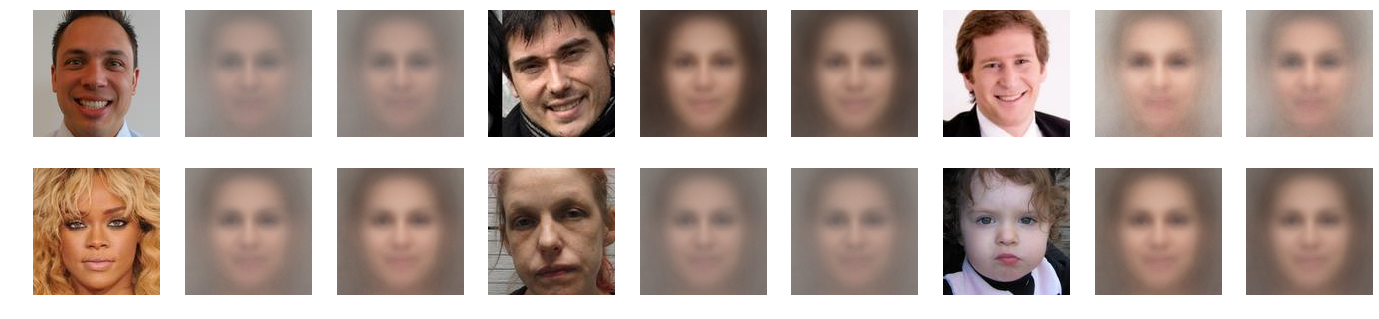

Epoch 2/1000
10000/10000 [==============================] - 13s 1ms/step - loss: 3128987.6950 - KL_loss: 5697.3220 - recon_loss: 3123290.3875 - val_loss: 3098297.2500 - val_KL_loss: 5871.5490 - val_recon_loss: 3092425.6500


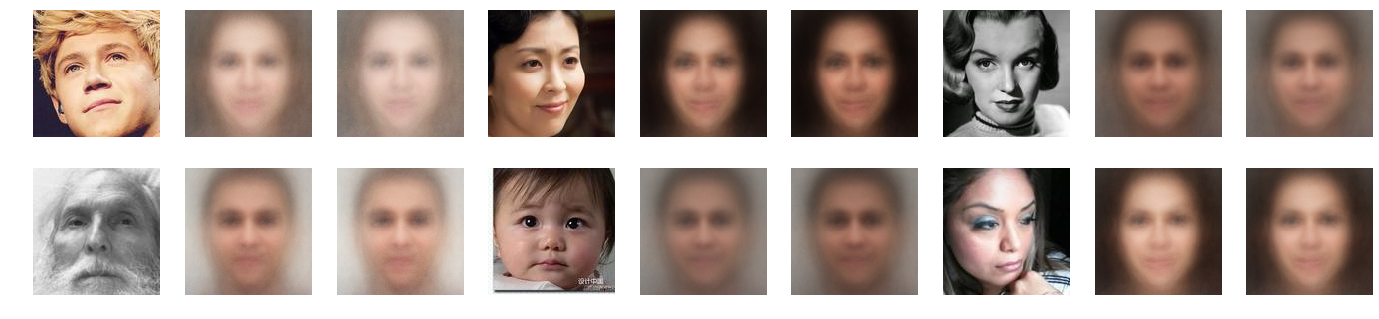

Epoch 3/1000
10000/10000 [==============================] - 13s 1ms/step - loss: 3081968.4750 - KL_loss: 4592.2521 - recon_loss: 3077376.2250 - val_loss: 3063535.4000 - val_KL_loss: 3758.0942 - val_recon_loss: 3059777.3250


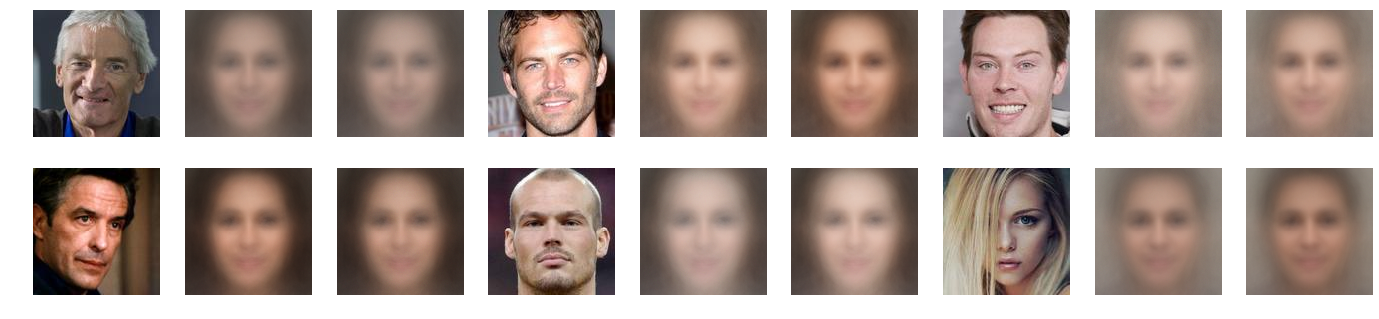

Epoch 4/1000
10000/10000 [==============================] - 12s 1ms/step - loss: 3061509.4825 - KL_loss: 2756.5483 - recon_loss: 3058752.9325 - val_loss: 3041567.6000 - val_KL_loss: 2094.8448 - val_recon_loss: 3039472.8750


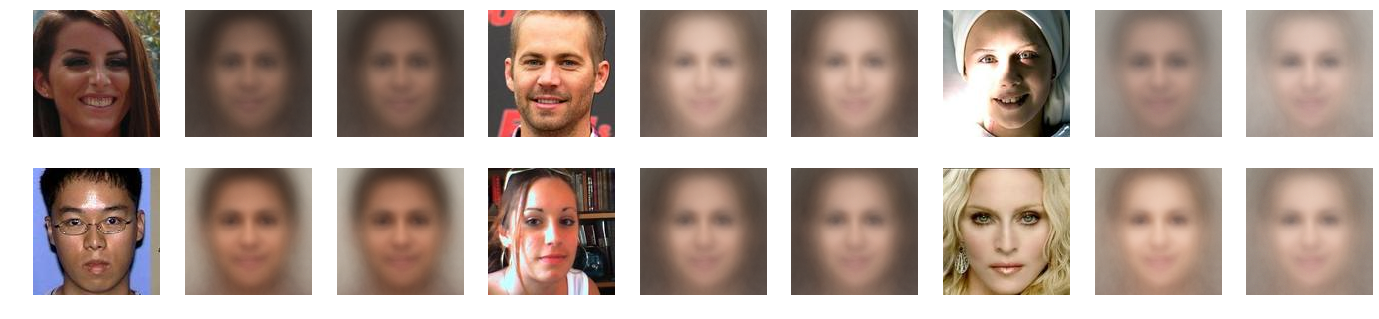

Epoch 5/1000
10000/10000 [==============================] - 14s 1ms/step - loss: 3037222.2575 - KL_loss: 1556.6759 - recon_loss: 3035665.5525 - val_loss: 3027647.6750 - val_KL_loss: 1085.5505 - val_recon_loss: 3026562.1500


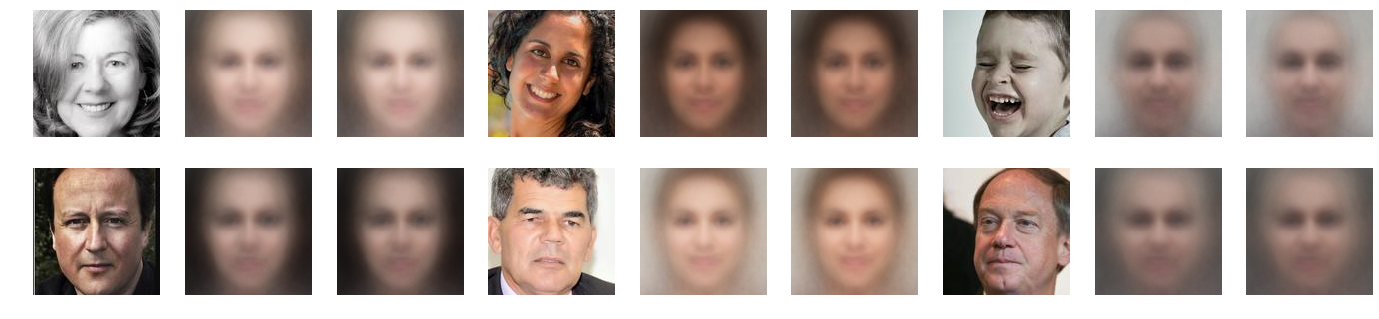

Epoch 6/1000
10000/10000 [==============================] - 13s 1ms/step - loss: 3009351.5300 - KL_loss: 889.9162 - recon_loss: 3008461.6150 - val_loss: 2993117.1250 - val_KL_loss: 804.3947 - val_recon_loss: 2992312.6500


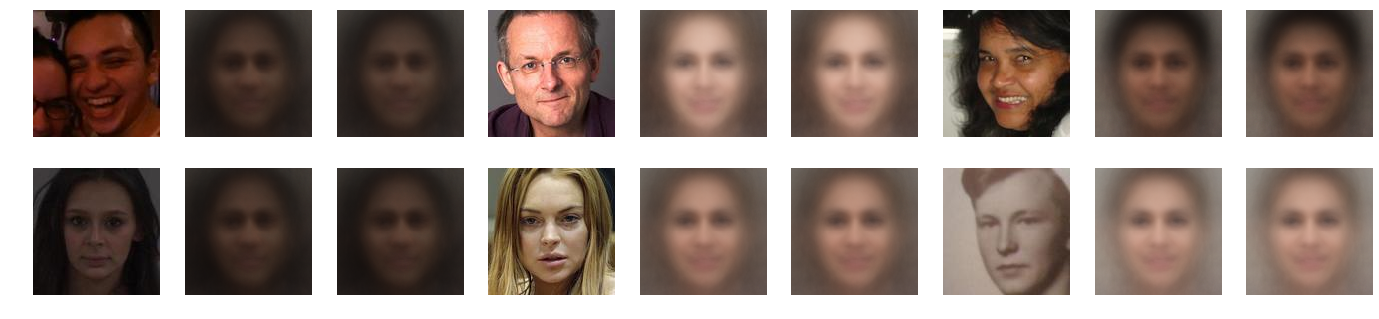

Epoch 7/1000
10000/10000 [==============================] - 12s 1ms/step - loss: 2985375.4725 - KL_loss: 763.1952 - recon_loss: 2984612.2650 - val_loss: 2964137.1250 - val_KL_loss: 753.5751 - val_recon_loss: 2963383.5500


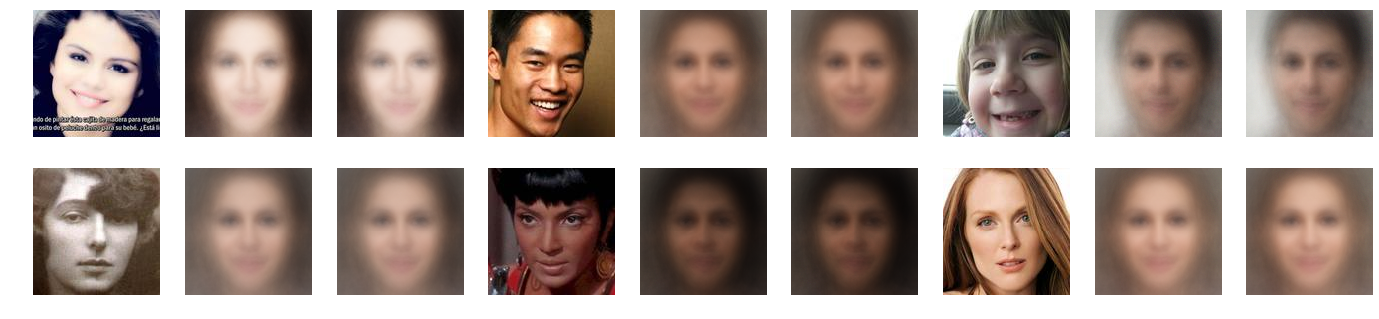

Epoch 8/1000
10000/10000 [==============================] - 12s 1ms/step - loss: 2952720.1300 - KL_loss: 752.0655 - recon_loss: 2951968.0775 - val_loss: 2933654.3500 - val_KL_loss: 757.2492 - val_recon_loss: 2932897.1000


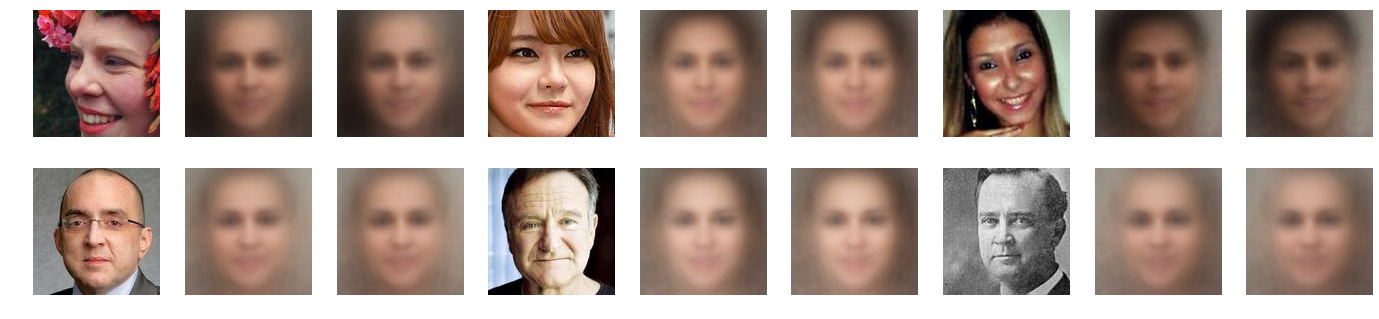

Epoch 9/1000
10000/10000 [==============================] - 12s 1ms/step - loss: 2926538.5100 - KL_loss: 755.4070 - recon_loss: 2925783.1075 - val_loss: 2906180.6750 - val_KL_loss: 789.5180 - val_recon_loss: 2905391.1500


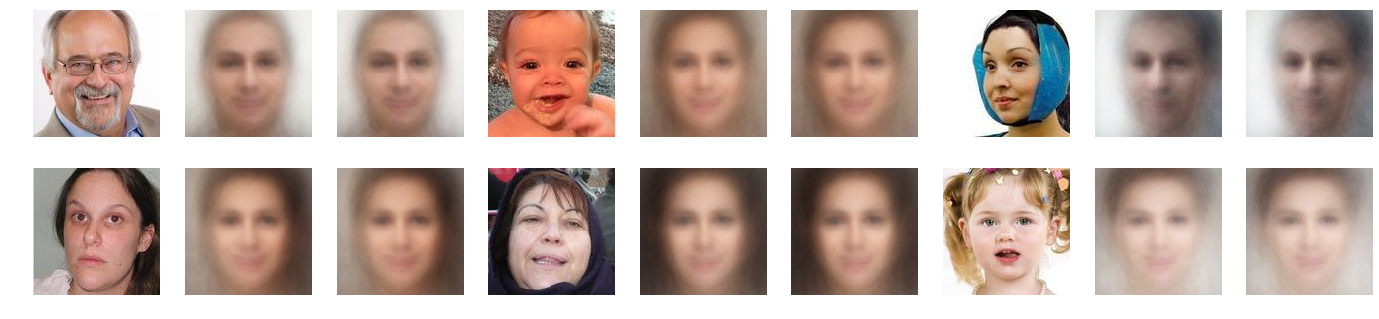

Epoch 10/1000
10000/10000 [==============================] - 12s 1ms/step - loss: 2916629.3750 - KL_loss: 767.6833 - recon_loss: 2915861.7175 - val_loss: 2907278.3750 - val_KL_loss: 746.8903 - val_recon_loss: 2906531.3500


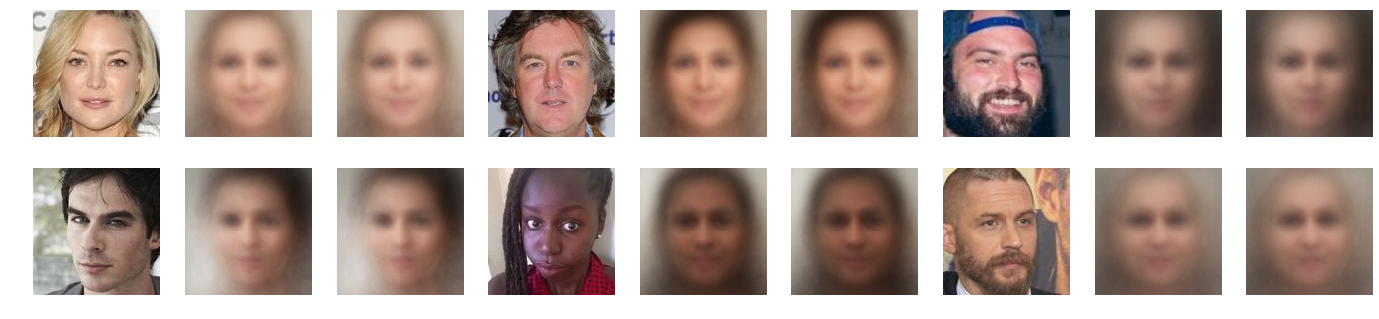

Epoch 11/1000
10000/10000 [==============================] - 12s 1ms/step - loss: 2911651.2825 - KL_loss: 730.5570 - recon_loss: 2910920.7200 - val_loss: 2895465.4250 - val_KL_loss: 760.4103 - val_recon_loss: 2894705.0500


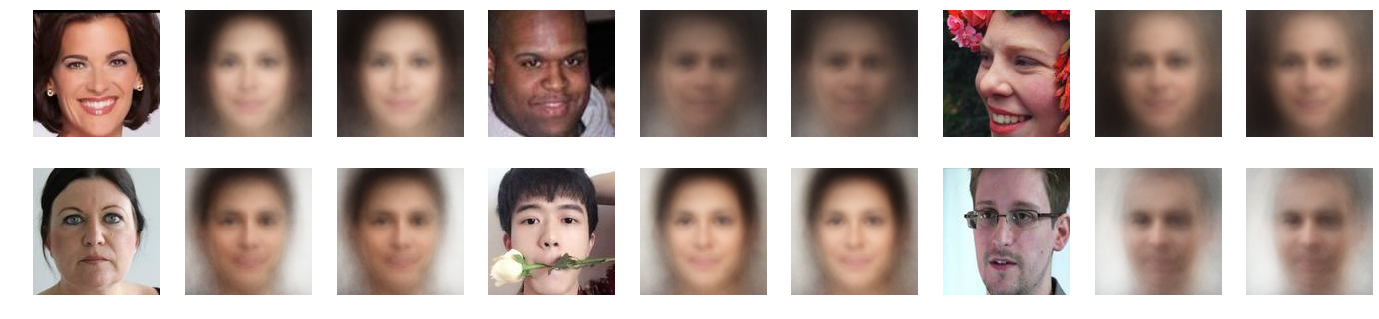

Epoch 12/1000
10000/10000 [==============================] - 12s 1ms/step - loss: 2907306.8700 - KL_loss: 741.7119 - recon_loss: 2906565.1350 - val_loss: 2889758.4250 - val_KL_loss: 742.4313 - val_recon_loss: 2889016.0000


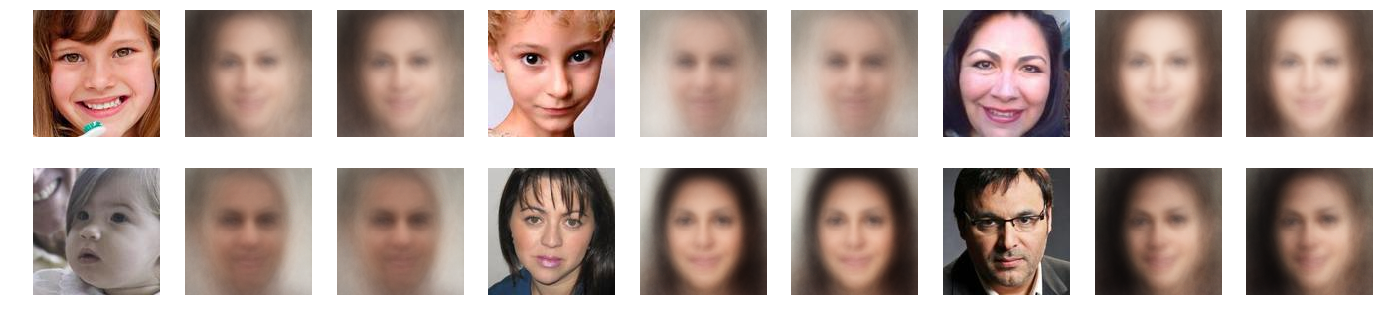

Epoch 13/1000
10000/10000 [==============================] - 11s 1ms/step - loss: 2905045.1900 - KL_loss: 680.6295 - recon_loss: 2904364.5675 - val_loss: 2883551.3250 - val_KL_loss: 678.2339 - val_recon_loss: 2882873.0750


KeyboardInterrupt: 

In [16]:
# compile and fit
cvae_hist = cvae.fit(
    X, y,
    verbose=1,
    batch_size=100,
    epochs=1000,
    validation_data=(V, v),
    callbacks=[
        EarlyStopping(patience=100),
        ShowSample(),
    ],
)

In [ ]:
np.random.choice(np.arange(10), 3)

TODO:

* сверточная сеть
* добавить тот крутой маленький датасет
* GAN+VAE